# Алгоритмы интеллектуальной обработки больших объемов данных
## Домашнее задание №4 - Алгоритмы кластеризации


###### <hr\>
**Общая информация**

**Срок сдачи:** 10 декабря 2019, 06:00 <br\>
**Штраф за опоздание:** -2 балла после 06:00 10 декабря, -4 балла после 06:00 17 декабря, -6 баллов после 06:00 24 декабря -8 баллов  после 06:00 31 декабря

При отправлении ДЗ указывайте фамилию в названии файла Присылать ДЗ необходимо в виде ссылки на свой github репозиторий на почту ml1.sphere@mail.ru с указанием темы в следующем формате:
[ML0919, Задание 4] Фамилия Имя

Используйте данный Ipython Notebook при оформлении домашнего задания.
<hr\>

**Из чего состоит задание:**

###### Теоретические вопросы (2 балла)

###### Реализация алгоритма кластеризации (5 баллов)

###### Боевое применение (3 балла)




**Штрафные баллы:**

1. Невыполнение PEP8 -1 балл
2. Отсутствие фамилии в имени скрипта (скрипт должен называться по аналогии со stroykova_hw4.ipynb) -1 балл
3. Все строчки должны быть выполнены. Нужно, чтобы output команды можно было увидеть уже в git'е. В противном случае -1 балл
4. При оформлении ДЗ нужно пользоваться данным файлом в качестве шаблона. Не нужно удалять и видоизменять написанный код и текст. В противном случае -1 балл

In [6]:
import time
import pandas as pd
import pylab as pl
import numpy as np
import scipy.spatial as ss
import sklearn.cluster as sc
import sklearn.manifold as sm
import sklearn.datasets as ds
import sklearn.metrics as smt
from sklearn.mixture import GaussianMixture
from sklearn.cluster import AgglomerativeClustering

import matplotlib.pyplot as plt

%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12,5)

# Plotting config
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/home/maxkile/.conda/envs/main/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['copy']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


# Теоретическое введение


Основная задача кластерного анализа — разбиение исходного набора объектов на группы (кластеры) таким образом, чтобы объекты в группе были похожи друг на друга, а объекты из разных групп - отличались. 

В этой работе мы будем реализовывать агломеративную кластеризацию. 

## Агломеративная кластеризация

Иерархические алгоритмы кластеризации строят на выборке систему вложенных разбиений.  Наиболее часто испоьзуемые иерархические алгоритмы - агломеративные алгоритмы, которые строят ирархию по восходящей, то есть от момента, когда все элементы являются отдельными кластерами, до того момента, пока вся выборка не станет одним кластером.

Сам алгоритм описать можно примерно так:

* начинаем с ситуации, когда каждый объект - отдельный кластер
* на каждом шаге совмещаем два наиболее близких кластера
* останавливаемся, когда получаем требуемое количество или единственный кластер


В данной работе Вам предлагается реализовать три варианта расстояний между кластерами, по которым Вы определяете пару для слияния: 
* Single linkage
$$ d_{min}(C_i, C_j) = \min_{\mathbf{x} \in C_i, \mathbf{x}' \in C_j} \|\mathbf{x} -\mathbf{x}' \| $$

* Complete linkage
$$ d_{max}(C_i, C_j) = \max_{\mathbf{x} \in C_i, \mathbf{x}' \in C_j} \|\mathbf{x} -\mathbf{x}' \| $$

* Average linkage
$$ d_{avg}(C_i, C_j) = \frac{1}{n_i n_j}\sum_{\mathbf{x} \in C_i}\sum_{\mathbf{x}' \in C_j} \|\mathbf{x} -\mathbf{x}' \| $$

Как считать расстояние $\|\mathbf{x} -\mathbf{x}' \|$ между объектами Вы должны выбрать сами.  Вы должны четко понимать, что выбор расстояния между объектами - самое важное в такого рода алгоритмах. Передавайте название расстояния в конструктор класса, а потом, в зависимости от названия, применяете ту или иную функцию для подсчета расстояния. 



Для того, чтобы на втором этапе нам не пересчитывать заново расстояния между всеми парами кластеров, можно использовать Формулы Ланса-Вильямса, которые позволяют посчитать расстояние между кластерами после объединения, используя только расстояния между кластерами до объедения.  Таким образом, достаточно будет посчитать расстояния только между всеми одноэлементными кластерами (первый этап), а затем пересчитывать расстояния при их объединении через 
формулы Ланса-Вильямса. 

Общая  формула выглядит так:
$$ d(C_i \cup C_j, C_k) = a_i \cdot d(C_i, C_k) + a_j \cdot d(C_j, C_k) + b \cdot d(C_i, C_j) + c \cdot |d(C_i, C_k) - d(C_j, C_k)|$$

Можно показать, что все относительно разумные кластерные расстояния можно описать данной формулой. 

Для интересущих нас linkage:

* single-linkage       $a_i = \frac{1}{2}, a_j =  \frac{1}{2}, b = 0, c =  - \frac{1}{2} $

* complete-linkage     $a_i = \frac{1}{2}, a_j =  \frac{1}{2}, b = 0, c =   \frac{1}{2} $

* average-linkage       $a_i = \frac{|C_i|}{|C_i \cup C_j|}, a_j =  \frac{|C_j|}{|C_i \cup C_j|}, b = 0, c = 0 $



# Теоретические вопросы (2 балла)
В этой части Вам будут предложены теоретичские вопросы и задачи по теме. Вы, конечно, можете списать их у своего товарища или найти решение в интернете, но учтите, что они обязательно войдут в теоретический коллоквиум. Лучше разобраться в теме сейчас и успешно ответить на коллоквиуме, чем списать, не разобравшись в материале, и быть терзаемым совестью. 


Формулы надо оформлять в формате **LaTeX**.

Задача 1. Сходимость kmeans.

Докажите, что kmeans всегда сходится, и итераций не будет превышать $k^N$, где $k$ $-$ число кластеров, $N$ $-$ число объектов

Подсказка: Вам стоит рассмотреть функционал, который минимизирует алгоритм, и подумать, как он изменяется на E шаге и на M шаге.



###### Решение:
Считаем индикатор $r_{n,k}$ так, что: $\| x_n -\nu_n \| \rightarrow$ min для $n$-го объекта.

Минимизируемый функционал монотонно не возрастает, так как на каждом шагу соответствующие расстояния неувеличиваются, а центры кластеров пересчитываются так, что функционал $Q$ минимизируется. В силу того, что кластеров конечное число K, монотонно невозрастающая функция достигнет минимума(может свалиться в локальный)ю

Число итераций не превышает число объектов в силу того, что $N$ объектов можно разбить на $k$ кластеров $k^{N}$ способами, а на каждом шаге мы кластеризуем лишь один объект $\Rightarrow$ всего итераций не больше $k^{N}$

Задача 2.  ММП для многомерного нормального распределения.

Функция правдоподобия в общем случае записывается как:
￼
￼$$ L(\theta) = p(X | \theta ) = \prod_{i=1}^N p(x_i | \theta)$$

Для многомерного нормального распределения плотность вероятности:
$$p(x_i| \theta) = \frac{1}{(2\pi)^{n/2}|\Sigma|^{1/2}}e^{-\frac{1}{2} (x_i - \mu)^T\Sigma^{-1}(x_i - \mu)}$$

Выведите ММП оценку для вектора $\mu$
￼

###### Решение: 
$X$ = ($X_1$,$X_2$,...,$X_n$)

$X_1$ = ($x_{1,1}$,$x_{1,2}$,...,$x_{1,m}$)

...

$X_n$ = ($x_{n,1}$,$x_{n,2}$,...,$x_{n,m}$)

Функция правдоподобия: $L(\theta)$ = $p(X|\theta)$ = $\prod\limits_{n = 1}^{N}$ $p(X_n|\theta)$ = $\frac{1}{(2\pi)^\frac{Nn}{2}|\sum^{\frac{N}{2}}|} \exp^{-\frac{1}{2}(X_1 - \mu)^{T}\sum^{-1}(X_1 - \mu) \space - \space ... \space - \space \frac{1}{2}(X_n - \mu)^{T}\sum^{-1}(X_n - \mu)}$
$\Rightarrow$

$\Rightarrow$ 
$\log{L(\theta)}$ = $-\frac{1}{2}(X_1 - thetamu)^{T}\sum^{-1}(X_1 - \theta) \space - \space ... \space - \space \frac{1}{2}(X_n - \theta)^{T}\sum^{-1}(X_n - \theta)$ - $\log(a)$, где a - константа.

Нули производной: $\frac{\partial \log{L(\theta)}}{\partial \theta}$ = $\frac{\partial }{\partial \theta}(-\frac{1}{2}(X_1 - \theta)^{T}\sum^{-1}(X_1 - \theta) \space - \space ... \space - \space \frac{1}{2}(X_n - \mu)^{T}\sum^{-1}(X_n - \theta))$ = 0 $\Leftrightarrow$

$\Leftrightarrow$
$\sum_{i = 1}^{N}(\sum^{-1} + (\sum^{-1})^{T})(X_i - \theta) = 0$
$\Leftrightarrow$

$\Leftrightarrow$
$\theta = \frac{\sum_{i = 1}^{n}X_i}{n}$



Задача 3. Формулы Ланса-Вильямса.

Формулы Ланса-Вильямса крайне удобны для быстрого пересчта расстояний в агломеративной кластеризации. Давайте докажем  формулы для single и complete linkage. 

Докажите, что:

$d_{\min}(U \cup V, S) = \frac{1}{2} d_{\min}(U, S) + \frac{1}{2} d_{\min}(V, S)  - \frac{1}{2} | d_{\min}(U, S) - d_{\min}(V, S) |  $


$d_{\max}(U \cup V, S) = \frac{1}{2} d_{\max}(U, S) + \frac{1}{2} d_{\max}(V, S)  + \frac{1}{2} | d_{\max}(U, S) - d_{\max}(V, S) |  $




##### Решение:


Заметим, что равенства выполняются для произвольных метрик и что:

$min(a,b) = \frac{a + b - |a - b|}{2}$

$max(a,b) = \frac{a + b + |a - b|}{2}$

В силу того, что расстояние между кластерами определено как расстояние между ближайшими (наиболее удаленными) элементами, то можно свести задачу к отысканию минимума(максимума) между двумя числами.

# Реализация алгоритма кластеризации  (5 баллов)

Алгоритм кластеризации должен удовлетворять следующему интерфейсу. Конструктор принимает набор параметров, необходимых для работы алгоритма кластеризации. Метод `fit` подсчитывает параметры модели и возвращает `self`. Метод `predict` возвращает вектор с индексами кластеров для поданных в него объектов `x`. 

In [128]:
import matplotlib.pyplot as plt
import copy

from sklearn.base import BaseEstimator, ClusterMixin
from scipy.cluster import hierarchy
from scipy.spatial.distance import cdist

class Clustering(BaseEstimator, ClusterMixin):
    """
    Implement clustering algorithm according 
    """
    
    def __init__(self, linkage='single',n_clusters = 2,metric='euclidean',p = 2):
        #linkages:single,complete
        self.metric = metric
        if (self.metric == 'minkowski'):
            self.p = p
        self.n_clusters = n_clusters
        self.linkage = linkage
        
        if linkage == 'single':
            self.alpha_i = 1/2
            self.alpha_j = 1/2
            self.gamma = -1/2
        elif linkage == 'complete':
            self.alpha_i = 1/2
            self.alpha_j = 1/2
            self.gamma = 1/2
        elif linkage == 'median':
            self.alpha_i = 1/2
            self.alpha_j = -1/4
            self.gamma = 0
        return
        
    def fit_predict(self, x):
        """
        Use data matrix x to compute model parameters and predict clusters
        """
        distances = cdist(x,x,self.metric)
        for i in range(len(x)):
            distances[i][i] = np.inf

        self.element_cluster = [[i] for i in range(len(x))]
                
        for i in range(distances.shape[0]):
            distances[i][i] = np.inf
            

        old = copy.deepcopy(self.element_cluster)
        
        cluster_div = list()
        for i in range(1,len(x)):#cluster unions number(objects - 1)
            ind = np.unravel_index(np.argmin(distances), distances.shape)#find minimal distance(it's index)
            
            if i == len(x) - self.n_clusters + 1:#here we have n_clusters,furher we continue unite clasters,so we must remember current cluster distribution and return it
                self.cluster_labels = copy.deepcopy(self.element_cluster)
                
            merging1 = self.element_cluster[ind[0]]#detecting merging clusters
            merging2 = self.element_cluster[ind[1]]
            
            self.element_cluster.remove(merging1)#deleting merging clusters
            self.element_cluster.remove(merging2)
            
            self.element_cluster.append(merging1+merging2)
            old.append(merging1+merging2)
            
            cluster_div.append([old.index(merging1), old.index(merging2), distances[ind[0],ind[1]], len(merging1) + len(merging2)])
            
            newdists = np.ones(distances.shape[0])
            newdists1 = np.ones(distances.shape[0]+1)
            
            if self.linkage=='average':
                self.alpha_i = len(merging1) / (len(merging1) + len(tomerge2))#changing coefficents for distances recounting(Lance-Williams)
                self.alpha_j = len(merging2) / (len(tomerge1) + len(tomerge2))
            elif self.linkage =='centroid':
                self.alpha_i = len(merging1) / (len(merging1) + len(tomerge2))
                self.alpha_j = - len(merging1) * len(merging2) / (len(tomerge1) + len(tomerge2))^2
                
            for j in range(distances.shape[0]):
                newdists[j] = self.alpha_i*distances[ind[0],j]+self.alpha_j*distances[ind[1],j]+self.gamma*abs(distances[ind[0],j]-distances[ind[1],j])
                newdists1[j] = copy.deepcopy(newdists[j])
                if j in ind:
                    newdists[j] = np.inf
                    newdists1[j] = np.inf        
            
            newdists=np.expand_dims(newdists, axis=1)
            distances=np.concatenate((distances, newdists), 1)
            
            newdists1[distances.shape[0]]=np.inf
            newdists1=np.expand_dims(newdists1, axis=0)
            
            distances=np.concatenate((distances, newdists1), 0)
            distances=np.delete(distances,(ind[0],ind[1]), 0)
            distances=np.delete(distances,(ind[0],ind[1]), 1)
            
#         self.element_cluster = old
        self.cluster_div=np.array(cluster_div)
    
        labels = np.ones(len(x))
        
        for lbl, num in enumerate(self.cluster_labels):
            labels[num] = lbl
        return labels
    
    def plot_dendrogram(self):
        hierarchy.dendrogram(self.cluster_div)

Сначала проверим реализованный алгоритм кластеризации на классическом наборе данных [Iris](http://www.wikiwand.com/en/Iris_flower_data_set). Загрузим данные (они включены в библиотеку sklearn) и посмотрим на то, как они выглядят в двух проекциях (для простоты используем 2 класса из 3).

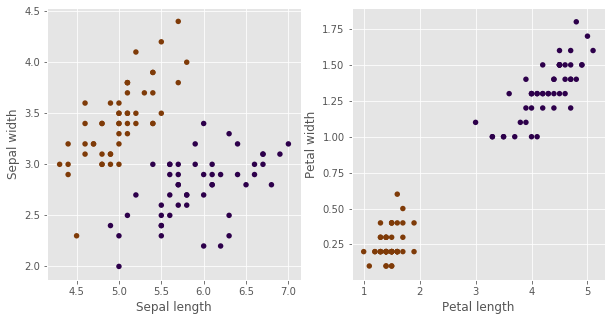

In [129]:
iris = ds.load_iris()
x_iris = iris.data[:100]
y_iris = iris.target[:100]

pl.figure(figsize=(10, 5))

pl.subplot(1, 2, 1)
pl.scatter(x_iris[:, 0], x_iris[:, 1], c=y_iris, cmap=pl.cm.PuOr, lw=0, s=30)
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')

pl.subplot(1, 2, 2)
pl.scatter(x_iris[:, 2], x_iris[:, 3], c=y_iris, cmap=pl.cm.PuOr, lw=0, s=30)
plt.xlabel('Petal length')
plt.ylabel('Petal width')
pl.show()

Видно, что классы разделяются, поэтому можно надеяться, что наш алгоритм "найдет" кластеры, соответствующие исходным классам. Результат работы реализованного алгоритма кластеризации предлагается сравнить с эталонной кластеризацией. Для этого предлагается изучить метрику ([adjusted rand score](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.adjusted_rand_score.html)). В случае если значение этой метрики отличается от 1, предлагается поработать над улучшением реализации своего алгоритма.

In [161]:
# Давайте проверим, как справляются sklearn реализации
sklearn_aggl = AgglomerativeClustering(n_clusters=2)
aggl_t0 = time.time()
aggl_pred = sklearn_aggl.fit_predict(x_iris)
aggl_diff = time.time() - aggl_t0
aggl_score = smt.adjusted_rand_score(y_iris, aggl_pred)
print (" Sklearn AGGL score {}. Sklearn AGGL time {}".format(aggl_score, aggl_diff))

 Sklearn AGGL score 1.0. Sklearn AGGL time 0.007863521575927734


In [154]:
# Здесь предскажем кластера, посчитаем метрику кластеризации и время работы, сравним со склерном
сustum_aggl = Clustering(metric='euclidean',n_clusters=2)
aggl_t0 = time.time()
aggl_pred = сustum_aggl.fit_predict(x_iris)
aggl_diff = time.time() - aggl_t0
aggl_score = smt.adjusted_rand_score(y_iris, aggl_pred)
print ("Our AGGL score {}. Our AGGL time {}".format(aggl_score, aggl_diff))

Our AGGL score 1.0. Our AGGL time 0.05158376693725586


/home/maxkile/.conda/envs/main/lib/python3.7/site-packages/ipykernel_launcher.py:80: RuntimeWarning: invalid value encountered in double_scalars


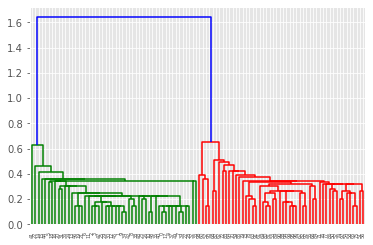

In [132]:
сustum_aggl.plot_dendrogram()

# Боевое применение (3  балла)


Алгоритмы кластеризации прекрасны тем, что они позволяют быстро понять, как устроены наши данные. Давайте применим Ваш алгоритм для нашего конкурса!

Будем рассматривать каждую группу независимо от других групп. На каждой группе применим наш алгоритм и отрисуем денденограмму. По результатам кластерного анализа, Вам нужно ответить на следующие вопросы:

1) Можно ли по дендонаграмме (или по другим результатам кластеризации) сказать, где в группе аномалии? Каким образом?

2) Какое расстояние лучше использовать между заголовками страниц для кластеризации? 

2) Какое качество f1_score Вы смогли получить на обучающем множестве методами кластеризации? (валидацию можете не делать, если таргет не используете)

4) Как можно результат кластеризации затем использовать для  финальной модели обучения с учителем?

Подсказка: самое важное - выбрать расстояние между заголовками. Самый простой вариант:  процент различных слов в двух заголовках.

In [8]:
doc_to_title = {}
with open('docs_titles.tsv') as f:
    for num_line, line in enumerate(f):
        if num_line == 0:
            continue
        data = line.strip().split('\t', 1)
        doc_id = int(data[0])
        if len(data) == 1:
            title = ''
        else:
            title = data[1]
        doc_to_title[doc_id] = title
print(len(doc_to_title))

28026


In [9]:
train_data = pd.read_csv('train_groups.csv')
traingroups_titledata = {}
for i in range(len(train_data)):
    new_doc = train_data.iloc[i]
    doc_group = new_doc['group_id']
    doc_id = new_doc['doc_id']
    target = new_doc['target']
    title = doc_to_title[doc_id]
    if doc_group not in traingroups_titledata:
        traingroups_titledata[doc_group] = []
    traingroups_titledata[doc_group].append((doc_id, title, target))

Кластеризацию проводите в каждой группе отдельно, то есть изучайте, можно ли в группе  найти подкластер выбросов

Документы можно представлять, например, словами из тайтла.

Главное подобрать хорошую функцию расстояния между документами


Замечание: в кластеризации можно использовать все данные, то есть трейн + тест, чтобы находить больше закономерностей 

In [11]:
# Место для Вашего кластерного анализа


Если получилось найти выбросы с помощью кластеризации, то не забывайте использовать его в финальном решении. Помните - использование различных подходов к решению задачи всегда улучшает финального качество.

Здесь Вы можете оставить отзыв о этой домашней работе или о всем курсе.   

*** ВАШ ОТЗЫВ ЗДЕСЬ***